In [1]:
from glob import glob
import geopandas as gpd
import pandas as pd
import altair as alt
import traceback
from shapely.geometry import Polygon
%matplotlib inline

In [2]:
def clip_line_poly(shp, clip_obj, extent, custom_extent=None):
    """Clip line and polygon geometry to the clip_obj GeoDataFrame extent.
    Clip an input line or polygon to the polygon extent of the clip_obj
    parameter. Lines or Polygons that intersect the clip_obj geometry are
    extracted with associated attributes and returned.
    Parameters
    ----------
    shp : GeoDataFrame
        Line or polygon geometry that is clipped to clip_obj.
    clip_obj : GeoDataFrame
        Reference polygon for clipping.
    extent: Boolean
        use envelope extent of clip_obj
    Returns
    -------
    GeoDataFrame
        The returned GeoDataFrame is a clipped subset of shp
        that intersects with clip_obj.
    """

    spatial_index = shp.sindex    
    # Create a single polygon object for clipping
    
    if extent:
        poly = clip_obj.geometry.envelope.unary_union
    else:
        poly = clip_obj.geometry.unary_union

    # Create a box for the initial intersection
    if custom_extent is not None:
        poly = Polygon([[custom_extent.minx, custom_extent.miny], 
                        [custom_extent.maxx, custom_extent.miny], 
                        [custom_extent.maxx, custom_extent.maxy], 
                        [custom_extent.minx, custom_extent.maxy]])
        bbox = custom_extent 
    else:
        bbox = poly.bounds
    
    # Get a list of id's for each object that overlaps the bounding box and
    # subset the data to just those lines
    sidx = list(spatial_index.intersection(bbox))
    shp_sub = shp.iloc[sidx]

    # Clip the data - with these data
    clipped = shp_sub.copy()
    clipped["geometry"] = shp_sub.intersection(poly)

    # Return the clipped layer with no null geometry values
    return clipped[clipped.geometry.notnull()]

In [12]:
def select_by_extent_GOI(GOI, shp_files, iter_bounds, gdf_base, custom_extent=None):
    idx_GOI = gdf_base[gdf_base['CODE'] == GOI].index[0]
    if custom_extent is not None:
        g_extent = custom_extent
        #custom_extent = (g_extent.minx, g_extent.miny, g_extent.maxx, g_extent.maxy)
    else:
        g_extent = iter_bounds[idx_GOI:idx_GOI+1][0][1]     
    

    list_intersection_geoms = []
    for shp in shp_files:
        try:            
            year = int(shp[-11:-7])
            month = int(shp[-6:-4])    
            gdf = gpd.read_file(shp)

            if 'GPGIDENT' in gdf.columns:
                object_id = 'GPGIDENT'
            else:
                object_id = 'CODE'             
            
            intersect_geoms = gdf.cx[g_extent.minx:g_extent.maxx, g_extent.miny:g_extent.maxy][[object_id,'geometry']]
            intersect_geoms.columns = ['OBJECTID', 'geometry']
            intersect_geoms.loc[:,"DATE"] = pd.datetime(year,month,1)
            #intersect_geoms.loc[:,"BASE_ID"] = gdf_base.iloc[idx]['CODE']
            list_intersection_geoms.extend(intersect_geoms.to_dict('records'))
        except Exception:
            traceback.print_exc()
            continue

    df_traject = pd.DataFrame.from_dict(list_intersection_geoms)
    gdf_traject = gpd.GeoDataFrame(df_traject)
    gdf_traject = alt.utils.sanitize_dataframe(gdf_traject)       
    
        
    gdf_traject = clip_line_poly(gdf_traject, gdf_base[gdf_base['CODE'] == GOI], 
                                 extent=True, custom_extent=custom_extent)
    
    return gdf_traject

In [35]:
def create_figure(gdf_traject):
    data  = alt.InlineData(values = gdf_traject.__geo_interface__,
                           format = alt.DataFormat(property='features',type='json')) 

    date_list = gdf_traject.DATE.unique().tolist()
    date_list.sort()

    geom_highlight = alt.selection_single(empty='none', on='mouseover')
    geom_stroke = alt.condition(
        geom_highlight,
        alt.value(5),
        alt.value(1)
    )
    
    date_dropdown = alt.binding_select(options=date_list)
    date_select = alt.selection_single(fields=['properties.DATE'], bind=date_dropdown, name="DATE", init={"properties.DATE":"2019-04-01T00:00:00"})

    chart = alt.Chart(data).mark_geoshape(
    ).encode( 
        fill=alt.Color('properties.OBJECTID:N', legend=None),
        stroke=alt.value('gray'),
        strokeWidth=geom_stroke
    ).properties(
        projection={'type': 'identity', 'reflectY': True, 'scale':50000, 'center':[0,0], 'rotate':[0,0,0]}
    ).add_selection(
        date_select,
        geom_highlight
    ).transform_filter(
        date_select
    )
    
    return chart

In [24]:
shp_files = glob(r"D:\Projects\Pr\4019.10\Werkmap_Joost\HDSR_TDLR\export_V2\**\*peil*.shp", recursive=True)
shp_base = glob(r"D:\Projects\Pr\4019.10\Werkmap_Joost\HDSR_TDLR\export_V2\**\*peil*2019_04*.shp", recursive=True)[0]
shp_update = glob(r"D:\Projects\Pr\4019.10\Werkmap_Joost\HDSR_TDLR\export_V2\**\*peil*2016_03*.shp", recursive=True)[0]

In [15]:
shp_base, shp_update

('D:\\Projects\\Pr\\4019.10\\Werkmap_Joost\\HDSR_TDLR\\export_V2\\Geodatadump_dissolved_2019_04\\Peilgebied_dissolved_2019_04.shp',
 'D:\\Projects\\Pr\\4019.10\\Werkmap_Joost\\HDSR_TDLR\\export_V2\\Geodatadump_dissolved_2016_03\\Peilgebied_dissolved_2016_03.shp')

In [16]:
gdf_base = gpd.read_file(shp_base)
bounds = gdf_base.bounds
iter_bounds = list(bounds.iterrows())

In [17]:
custom_extent = pd.Series(data=[141573,447266,142600,447906], index=['minx','miny','maxx', 'maxy'])

In [18]:
GOI = 'PG2088'

In [19]:
# gdf_base_mpg = gdf_base[gdf_base.geometry.type == 'MultiPolygon']
# gdf_update_mpg = gdf_update[gdf_update.geometry.type == 'MultiPolygon']

In [20]:
gdf_traject = select_by_extent_GOI(GOI, shp_files, iter_bounds, gdf_base, custom_extent)

In [21]:
gdf_traject.head()

,DATE,OBJECTID,geometry
6,2013-07-01T00:00:00,PG0577,"POLYGON ((142600 447669.4796363699, 142560.652..."
22,2013-09-01T00:00:00,PG0577,"POLYGON ((142058.1652134218 447266, 142055.58 ..."
125,2014-10-01T00:00:00,PG0577,"POLYGON ((142058.1652134218 447266, 142055.58 ..."
173,2015-04-01T00:00:00,PG0577,"POLYGON ((142058.1652134218 447266, 142055.58 ..."
62,2014-02-01T00:00:00,PG0577,"POLYGON ((142058.1652134218 447266, 142055.58 ..."


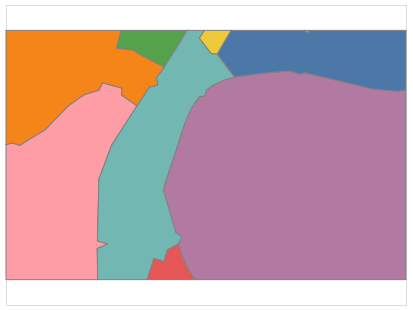

In [36]:
create_figure(gdf_traject)

In [ ]:
gdf_traject